In [110]:
from scripts.interactive_search import *
import networkx as nx
import numpy as np
from networkx.algorithms import community
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from NLP.tokenizer import clean_and_tokenize

In [111]:
# Change this function to select a different paper set
def read_metadata(path):
    df = pd.read_csv(path)
    df = df.astype({'abstract': 'str'})
    df = df[df['abstract'] != 'Unknown']
    df = df[df['abstract'] != 'nan']
    df = df[df['language'] == 'en']
    df = df[df['publish_time'].str[:4] == '2020']
    df = df.drop_duplicates(['title','abstract'])
    df = df.reset_index(drop=True)
    df = df[:1000]
    return df

In [115]:
load_from_pickle = True
#EMBEDDINGS_PATH = 'data/embeddings_top5k.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020.pkl'
EMBEDDINGS_PATH = 'data/embeddings_2020_top1k.pkl'
#METADATA_PATH = 'data/metadata_new_new.csv'
METADATA_PATH = 'data/metadata_en_20_topics.csv'

df_meta = read_metadata(METADATA_PATH)
abstracts = [a for a in df_meta['abstract']]
titles = df_meta['title'].reset_index(drop=True)

if load_from_pickle:
    with open(EMBEDDINGS_PATH, 'rb') as file:
        embeddings = pickle.load(file)

else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(abstracts, show_progress_bar=True)
    with open(EMBEDDINGS_PATH, 'wb') as file:
        pickle.dump(embeddings, file)

In [117]:
# Replace NaN values in the topics by 0.0
for i in range(0, 8):
    topic_series = df_meta['topic_' + repr(i)]
    topic_series[topic_series.isna()] = 0.0
    df_meta['topic_' + repr(i)] = topic_series

In [118]:
topic_strings = []
for i in range(0, 8):
    topic_strings.append('topic_' + repr(i))

df_meta['topic'] = df_meta[topic_strings].idxmax(axis=1).str[-1:]

In [119]:
topics = df_meta['topic']
topics.value_counts()

2    254
6    183
1    144
5    129
3     93
0     83
7     71
4     43
Name: topic, dtype: int64

In [120]:
X = np.asarray(embeddings)

In [121]:
X.shape

(1000, 768)

In [122]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from mpl_toolkits.mplot3d import Axes3D

# This cell can take a few minutes to run
run_this_cell = False
n_clusters = 8

if run_this_cell:
    # In 2d
    methods = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in methods:
        X_embedded = embedding.fit_transform(X)
        fig = plt.figure()
        kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
        y_pred = kmeans.predict(X_embedded)
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_pred)
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    methods = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in methods:
        X_embedded = embedding.fit_transform(X)
        fig = plt.figure()
        ax = Axes3D(fig)
        kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
        y_pred = kmeans.predict(X_embedded)
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y_pred)
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In [123]:
def compute_clusters_spacial(X, method='pca', dim=2, n_clusters=8, dtype='title'):
    clusters = []
    for i in range(n_clusters):
        if dtype == 'title':
            clusters.append(set())
        elif dtype == 'topic':
            clusters.append([])
        else:
            print('Unknown dtype')
        
    if method == 'pca':
        algo = PCA(n_components=dim, copy=True, whiten=True, tol=1e-5)
    elif method == 'isomap':
        algo = Isomap(n_components=dim, n_neighbors=5)
    elif method == 'tsne':
        algo = TSNE(n_components=dim)
    else:
        print("Unknown embedding method")
    
    X_embedded = algo.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
    classes = kmeans.predict(X_embedded)
    for i in range(len(classes)):
        if dtype == 'title':
            clusters[classes[i]].add(titles[i])
        elif dtype == 'topic':
            clusters[classes[i]].append(topics[i])
        
    return clusters

In [124]:
def compute_adjacency(embeddings, epsilon):
    cosine_distances = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    cosine_similarities = 1 - cosine_distances
    cosine_similarities[cosine_similarities < epsilon] = 0
    np.fill_diagonal(cosine_similarities, 0.0)
    return cosine_similarities

In [125]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # We apply the formulas from the lecture
    D = np.diag(np.sum(adjacency, axis=0))
    L = D - adjacency
    if normalize: 
        D2 = np.diag(np.sum(adjacency, axis=0) ** (-1/2))
        Ln = np.dot(np.dot(D2, L), D2)
        return Ln
    else:
        return L

In [126]:
epsilon = 0.85
adjacency = compute_adjacency(embeddings, epsilon)

In [127]:
print("Non-zero weight percentage: " + '{0:.2f}'.format(adjacency[adjacency!=0].size * 100 / adjacency.size) + '%')

Non-zero weight percentage: 4.50%


In [128]:
G = nx.from_numpy_array(adjacency)
print("Number of connected components: " + repr(nx.number_connected_components(G)))

Number of connected components: 242


In [129]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [130]:
subgraphs = sorted(list(connected_component_subgraphs(G)), key=len, reverse=True) # Use this for version 2.4+ of networkx

In [131]:
G = subgraphs[0]  # Keep only the main connected component

In [132]:
adjacency = np.asarray(nx.to_numpy_matrix(G))

In [133]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

In [134]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    e_values, e_vectors = np.linalg.eigh(laplacian)

    return e_values, e_vectors.T # We transpose the eigenvectors so that e_vectors[k] is the k-th eigenvector (instead of e_vectors[:, k])

In [135]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

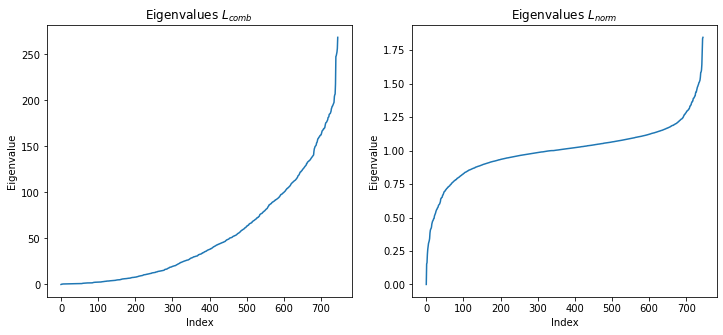

In [136]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [139]:
index_to_title = {}
title_to_index = {}
for i in list(G.nodes):
    index_to_title.update({i: titles[i]})
    title_to_index.update({titles[i]: i})

In [140]:
G = nx.relabel.relabel_nodes(G, index_to_title)

In [141]:
def compute_clusters_girvan(G, iterations, dtype='title'):
    if dtype == 'title':
        G = nx.relabel.relabel_nodes(G, index_to_title)
    elif dtype == 'topic':
        G = nx.relabel.relabel_nodes(G, title_to_index)
        
    generator = community.centrality.girvan_newman(G)
    for i in range(0, iterations):
        print("Computing clusters, iteration " + repr(i+1) + '/' + repr(iterations), end='\r')
        clusters = next(generator)
        
    if dtype == 'title':
        return clusters
    elif dtype == 'topic':
        clusters_topic = []
        for cluster in range(len(clusters)):
            clusters_topic.append([])
            for i in clusters[cluster]:
                clusters_topic[cluster].append(topics[i])
        return clusters_topic

In [153]:
def compute_clusters_fluid(G, n_clusters=10, dtype='title'):
    if dtype == 'title':
        G = nx.relabel.relabel_nodes(G, index_to_title)
    elif dtype == 'topic':
        G = nx.relabel.relabel_nodes(G, title_to_index)
    
    clusters = []
    iterator = community.asyn_fluidc(G, n_clusters, max_iter=1)
    for cluster in iterator:
        clusters.append(cluster)
        
    if dtype == 'title':
        return clusters
    elif dtype == 'topic':
        clusters_topic = []
        for cluster in range(len(clusters)):
            clusters_topic.append([])
            for i in clusters[cluster]:
                clusters_topic[cluster].append(topics[i])
        return clusters_topic

In [143]:
def compute_clusters_lpa(G, dtype='title'):
    if dtype == 'title':
        G = nx.relabel.relabel_nodes(G, index_to_title)
    elif dtype == 'topic':
        G = nx.relabel.relabel_nodes(G, title_to_index)
    
    clusters = []
    iterator = community.asyn_lpa_communities(G, 'weight')
    for cluster in iterator:
        clusters.append(cluster)
        
    if dtype == 'title':
        return clusters
    elif dtype == 'topic':
        clusters_topic = []
        for cluster in range(len(clusters)):
            clusters_topic.append([])
            for i in clusters[cluster]:
                clusters_topic[cluster].append(topics[i])
        return clusters_topic

In [144]:
def compute_clusters_nlp(G, dtype='title'):
    G = nx.relabel.relabel_nodes(G, title_to_index)
        
    clusters = []
    for topic in range(0, 8):
        if dtype == 'title':
            clusters.append(set())
        elif dtype == 'topic':
            clusters.append([])
        
    for node in G.nodes:
        if dtype == 'title':
            clusters[int(topics[node])].add(titles[node])
        elif dtype == 'topic':
            clusters[int(topics[node])].append(topics[node])
        
    return clusters

In [145]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\val\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
stop_words = set(stopwords.words('english'))
stop_words.add('coronavirus')
stop_words.add('virus')
stop_words.add('novel')
stop_words.add('chapter')
stop_words.add('covid-19')
stop_words.add('sars-cov-2')
stop_words.add('2019')
stop_words.add('2020')
stop_words.add('using')
stop_words.add('2019-ncov')

In [154]:
dtype = 'title'

#clusters = compute_clusters_lpa(G, dtype=dtype)  # Poor results
clusters = compute_clusters_fluid(G, n_clusters=3, dtype=dtype)  # Works quite well with high epsilon (.85) and only keeping main connected component
#clusters = compute_clusters_girvan(G, iterations=3, dtype=dtype)  # Takes forever to compute on big graphs
#clusters = compute_clusters_spacial(X, method='pca', dim=2, n_clusters=8, dtype=dtype)
#clusters = compute_clusters_nlp(G, dtype=dtype)
for cluster in clusters:
    print(len(cluster))

203
197
339


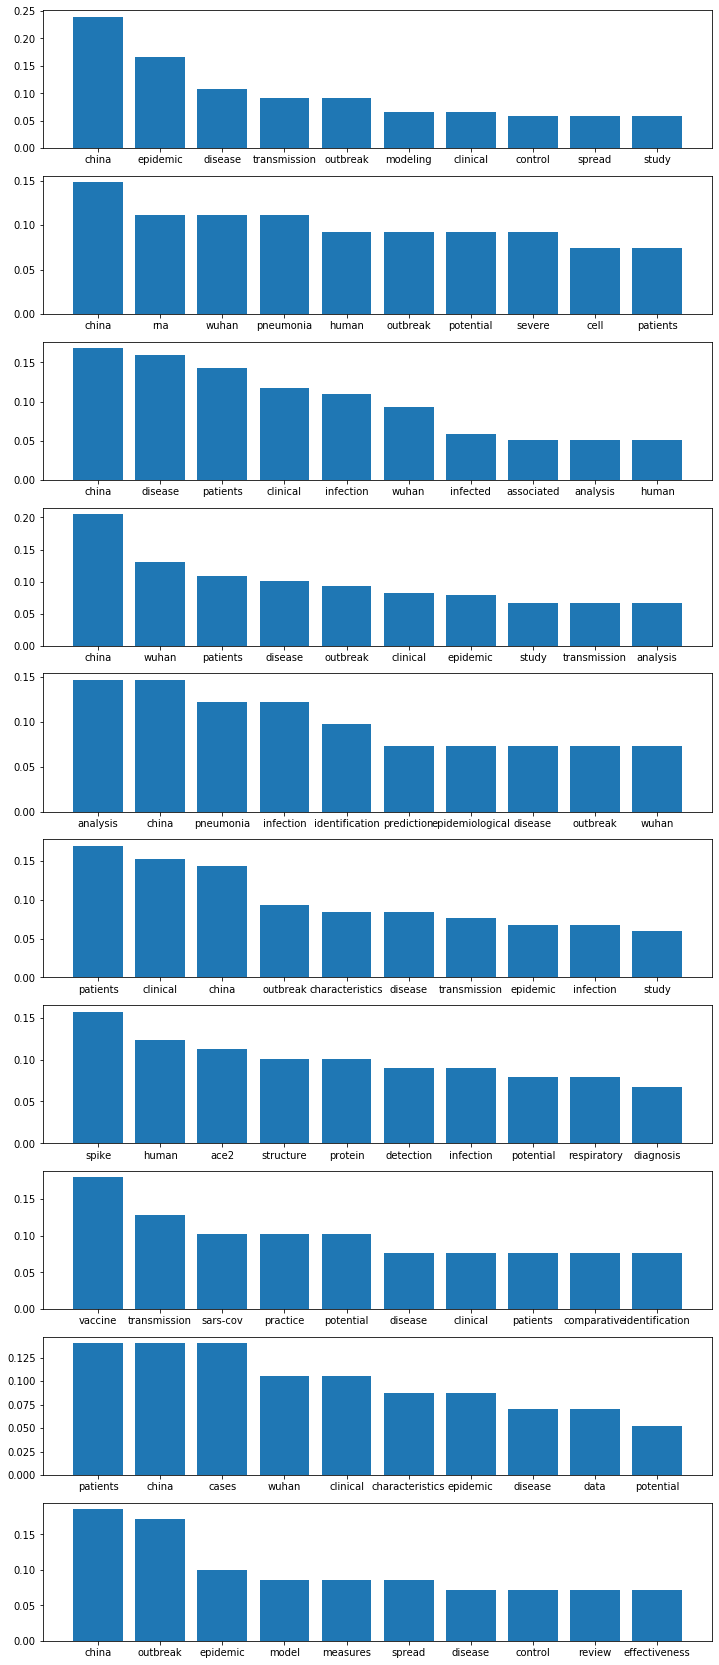

In [148]:
min_community_size = 0
top_k = 10
title_to_cluster = {}

if dtype == 'title':
    fig, ax =  plt.subplots(len(clusters))
    fig.set_size_inches(12, 30)
    i = 0
    for cluster in clusters:
        if len(cluster) < min_community_size:
            continue
        word_count = {}
        for title in cluster:
            title_to_cluster.update({title: i})
            if type(title) != str:
                print("Error: title is not a string => " + repr(title))
            tokens = clean_and_tokenize(title)
            for token in tokens:
                if token in stop_words:
                    continue
                if token in word_count.keys():
                    word_count[token] += 1
                else:
                    word_count[token] = 1

        x = sorted(word_count, key=word_count.get, reverse=True)[:top_k]
        height = sorted(word_count.values(), reverse=True)[:top_k]
        norm = [float(i)/sum(height) for i in height]
        ax[i].bar(x, norm)
        i += 1
    plt.show()
    nx.set_node_attributes(G, title_to_cluster, "cluster")

In [149]:
min_community_size = 0
top_k = 10
X_topics = np.ndarray((len(clusters), 8))
if dtype == 'topic':
    fig, ax =  plt.subplots(len(clusters))
    fig.set_size_inches(12, 30)
    i = 0
    for cluster in clusters:
        if len(cluster) < min_community_size:
            continue
        topic_count = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0}
        for topics_ in cluster:
            for topic in topics_:
                topic_count[topic] += 1

        x = topic_count.keys()
        height = topic_count.values()
        norm = [float(i)/sum(height) for i in height]
        X_topics[i] = np.asarray(norm)
        ax[i].bar(x, norm)
        i += 1
    plt.show()

In [150]:
u, s, v = np.linalg.svd(X_topics)

LinAlgError: SVD did not converge

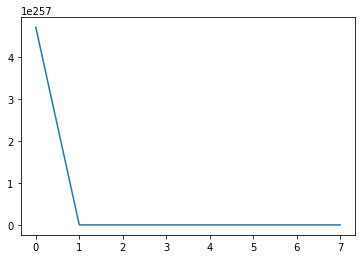

In [151]:
plt.plot(s)

In [152]:
nx.write_gexf(G, "data/graph.gexf")

The end.